In [1]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

pl.Config.set_tbl_rows(6)

polars.config.Config

## All charts are from https://www.youtube.com/watch?v=cF16lDtSVrU.

### Read in temperature dataset

In [2]:
df = pl.read_parquet('ushcn_monthly_data.parquet')
df

coop_id,year,month,element,dataset_type,value,dmflag,qcflag,dsflag
str,u16,u8,str,str,f64,str,str,str
"""231037""",1893,1,"""tmax""","""raw""",-0.24,null,null,null
"""231037""",1893,2,"""tmax""","""raw""",3.15,null,null,null
"""231037""",1893,3,"""tmax""","""raw""",11.96,"""b""",null,null
…,…,…,…,…,…,…,…,…
"""189440""",2025,10,"""tmax""","""FLs.52j""",null,null,null,null
"""189440""",2025,11,"""tmax""","""FLs.52j""",null,null,null,null
"""189440""",2025,12,"""tmax""","""FLs.52j""",null,null,null,null


In [3]:
with pl.Config(
    set_tbl_rows=10,
):
    display(df.describe())

statistic,coop_id,year,month,element,dataset_type,value,dmflag,qcflag,dsflag
str,str,f64,f64,str,str,f64,str,str,str
"""count""","""5509920""",5.50992e6,5.50992e6,"""5509920""","""5509920""",5.350524e6,"""1293650""","""101343""","""176205"""
"""null_count""","""0""",0.0,0.0,"""0""","""0""",159396.0,"""4216270""","""5408577""","""5333715"""
"""mean""",null,1958.974316,6.5,null,null,18.076439,null,null,null
"""std""",null,37.33781,3.452053,null,null,10.639119,null,null,null
"""min""","""011084""",1853.0,1.0,"""tmax""","""FLs.52j""",-23.73,""".""","""F""","""0"""
"""25%""",null,1928.0,4.0,null,null,10.1,null,null,null
"""50%""",null,1959.0,7.0,null,null,19.3,null,null,null
"""75%""",null,1991.0,9.0,null,null,26.81,null,null,null
"""max""","""489905""",2025.0,12.0,"""tmax""","""tob""",51.02,"""i""","""X""","""G"""


### Replicate Chart 1 (1:31):  raw, averaged July max temps from 1895 to 2021 chart

Conclusion:  seemingly perfectly replicated

In [4]:
def make_july_temps_df(df, dataset_type):
    return (
        df
        .filter(
            pl.col('element') == 'tmax',
            pl.col('dataset_type') == dataset_type,
            pl.col('value').is_not_null(),  
            pl.col('year') >= 1895,
            pl.col('month') == 7
        )
        .group_by('year')
        .agg(
            pl.col('value').mean().alias('july_mean'),
        )
        .sort('year')
        .with_columns(
            (pl.col('july_mean') * 9/5 + 32).alias('july_mean'),
            (pl.col('july_mean') * 9/5 + 32).rolling_mean(window_size=5, center=True).alias('july_mean_5yr'),
            (pl.col('july_mean') * 9/5 + 32).rolling_mean(window_size=9, center=True).alias('july_mean_9yr')
        )
    )

In [5]:
def calc_best_fit_line(x, y):
    coeffs = np.polyfit(x, y, 1)
    return np.polyval(coeffs, x), coeffs[0], coeffs[1]

In [6]:
def make_july_chart(df, dataset_type):
    df = make_july_temps_df(df, dataset_type)

    # Determine the best fit line
    best_fit_line = calc_best_fit_line(df['year'], df['july_mean'])[0]
    
    # Plot the data
    plt.figure(figsize=(9, 5))
    plt.plot(df['year'], df['july_mean'], color='grey', label='July Mean')
    # plt.scatter(df['year'], df['july_mean'], color='grey', marker='o', s=10)
    plt.plot(df['year'], df['july_mean_5yr'], color='red', linewidth=2, label='5-Year Rolling Mean')
    plt.plot(df['year'], best_fit_line, color='green', linestyle='-', label='Linear Best Fit')
    plt.title(f'July Mean TMAX (1895-present)\nDataset Type: {dataset_type}')
    plt.xlabel('Year')
    plt.ylabel('Temperature (°F)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

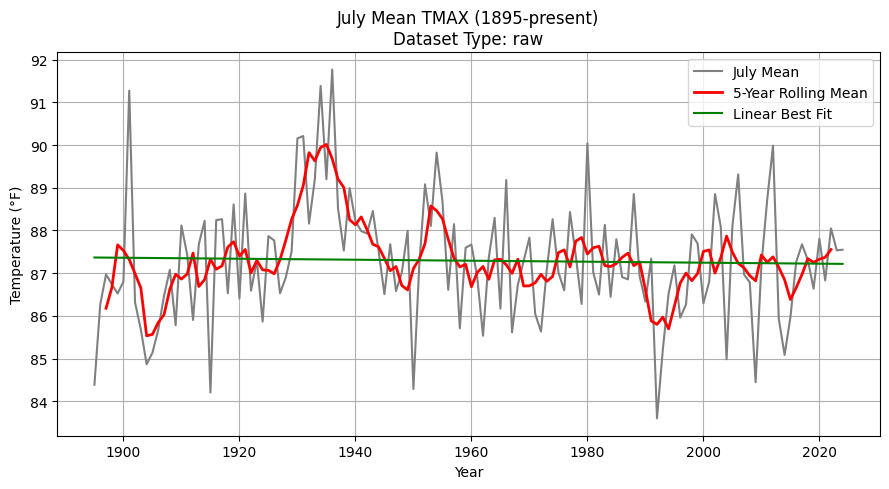

In [7]:
make_july_chart(df, 'raw')

### Replicate Chart 2 (2:07):  altered, averaged July max temps from 1895 to 2021 chart

Conclusion:  seemingly perfectly replicated

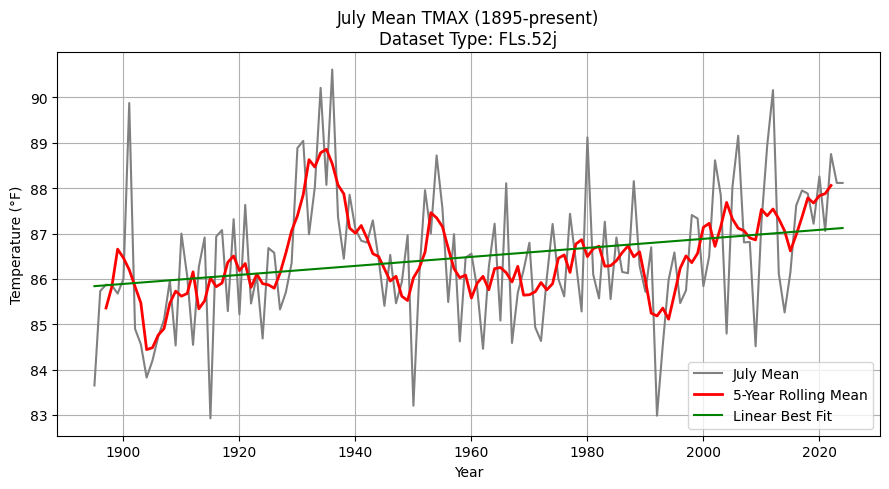

In [8]:
make_july_chart(df, 'FLs.52j')

### Replicate Chart 3 (2:37) - overlaid (raw & altered) July TMAX 

Conclusion:  seemingly perfectly replicated

In [9]:
def make_overlaid_july_chart(df):
    # Make dfs
    raw = make_july_temps_df(df, 'raw')
    altered = make_july_temps_df(df, 'FLs.52j')
    combined = (
        raw
        .join(altered, on='year', how='inner', suffix='_altered')
    )

    # Get the best fit lines
    raw_fit_line = calc_best_fit_line(combined['year'], combined['july_mean'])[0]
    altered_fit_line = calc_best_fit_line(combined['year'], combined['july_mean_altered'])[0]

    # Plot the data
    plt.figure(figsize=(9, 5))
    plt.plot(combined['year'], combined['july_mean_9yr'], color='blue', linewidth=2, label='Raw, 9-Year Rolling Mean')
    plt.plot(combined['year'], raw_fit_line, color='blue', linestyle='-')
    plt.plot(combined['year'], combined['july_mean_9yr_altered'], color='red', linewidth=2, label='Altered, 9-Year Rolling Mean')
    plt.plot(combined['year'], altered_fit_line, color='red', linestyle='-')
    plt.title('July Mean TMAX (1895-present)\nCombined')
    plt.xlabel('Year')
    plt.ylabel('Temperature (°F)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

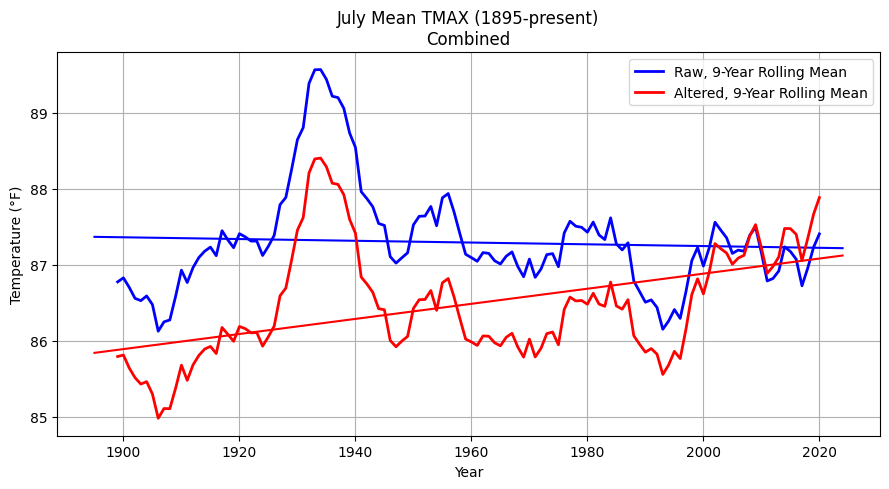

In [10]:
make_overlaid_july_chart(df)

### Replicate Chart 4 (3:03) - Raw - Altered

Conclusion:  seemingly perfectly replicated

In [11]:
def make_diffs_july_chart(df):
    # Make dfs
    raw = make_july_temps_df(df, 'raw')
    altered = make_july_temps_df(df, 'FLs.52j')
    combined = (
        raw
        .join(altered, on='year', how='inner', suffix='_altered')
        .with_columns(
            (pl.col('july_mean_altered') - pl.col('july_mean')).alias('diff'),
            (pl.col('july_mean_altered') - pl.col('july_mean')).rolling_mean(5, center=True).alias('diff_5yr'),
        )
    )

    # Plot the data
    plt.figure(figsize=(9, 5))
    plt.plot(combined['year'], combined['diff'], color='grey', linewidth=2, label='Raw - Altered')
    plt.plot(combined['year'], combined['diff_5yr'], color='green', linewidth=2, label='Raw - Altered, 5-Year Rolling Mean')
    plt.title('July Mean TMAX (1895-present)\nRaw - Altered')
    plt.xlabel('Year')
    plt.ylabel('Temperature Difference (°F)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    return


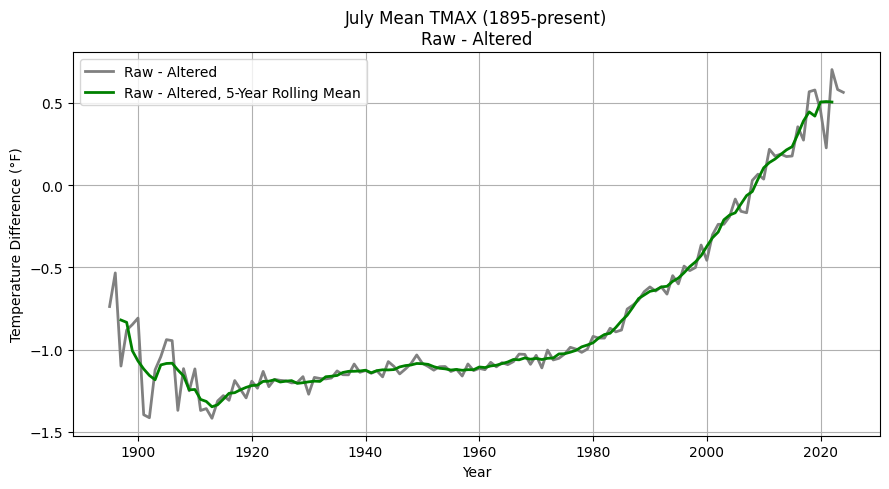

In [12]:
make_diffs_july_chart(df) # this averages the july's and then calcs the diffs
                          # v2 calcs the diffs and then averages

### Replicate Chart 5 (3:27) - NOAA July Global Land and Ocean Average Temperature Anomalies

Chart was screen shotted from https://www.ncei.noaa.gov/access/monitoring/monthly-report/global/202407 on 4/21/2025.

![](/background/chart_5.png)

Note:  there is no replication going on for this chart...just a straight up copy.

NB:  "Anomalies" refer to the difference in temperature from the 20th century average (of 15.8 C, 60.4 F).  This implies the 20th century average is what the Earth's normal July temperature should be.

### Replicate Chart 6 (3:33) - CO2 ppm trend

No idea where this chart came from.  There is one data point every 20 years.

### Replicate Chart 7 (3:57) - # of stations

Discrepancy:  OG chart shows 830 stations in 2020.  I show 848.

In [13]:
stations = (
    df
    .filter(
        pl.col('element') == 'tmax',
        pl.col('dataset_type') == 'raw',
        pl.col('value').is_not_null(),
        pl.col('year').is_between(1920, 2024),
    )
    .group_by(['year'])
    .agg(
        pl.col('coop_id').n_unique().alias('n_stations'),
        pl.col('value').mean().alias('tmax_mean'),
    )
    .sort(['year'])
)
stations

year,n_stations,tmax_mean
u16,u32,f64
1920,1147,17.746588
1921,1152,19.637958
1922,1156,18.621562
…,…,…
2022,825,18.152915
2023,815,18.599645
2024,800,19.147224


#### Claim 1 (4:06): Max # of stations was 1,218, in 1957.

Conclusion:  Confirmed.

In [14]:
# Corroborate which year the maximum number of stations was recorded
stations.filter(pl.col('n_stations') == pl.col('n_stations').max())

year,n_stations,tmax_mean
u16,u32,f64
1957,1218,18.288359


#### Claim 2 (4:15):  After 1990, # of stations began rapidly falling due to equipment aging and personnel retirements.

Conclusion:  The rapid decrease is confirmed but there is no way to attritube the cause(s) solely from the data.

#### Claim 3 (4:27):  By 2020, # of active stations dropped to 830.

Conclusion:  Not confirmed.  Though directionally similar, I find 848 stations in 2020.

#### Claim 4 (4:33):  In order to maintain 1,218 stations, NOAA creates temperature data for each inactive station.

Conclusion:  unresearched

#### Claim 5 (4:45) - NOAA created data for 378 stations that had stopped reporting data.

Conclusion:  Not a unique claim...same as Claim 4.  

Simple subtraction seems to be how this number was calculated, aided by a typo or poor arithmetic:  1,218 - 830 = 388.

In [15]:
point_1957 = stations.filter(pl.col('year') == 1957)
point_2020 = stations.filter(pl.col('year') == 2020)

In [16]:
x_1957 = point_1957['year'][0]
y_1957 = point_1957['n_stations'][0]
x_2020 = point_2020['year'][0]
y_2020 = point_2020['n_stations'][0]

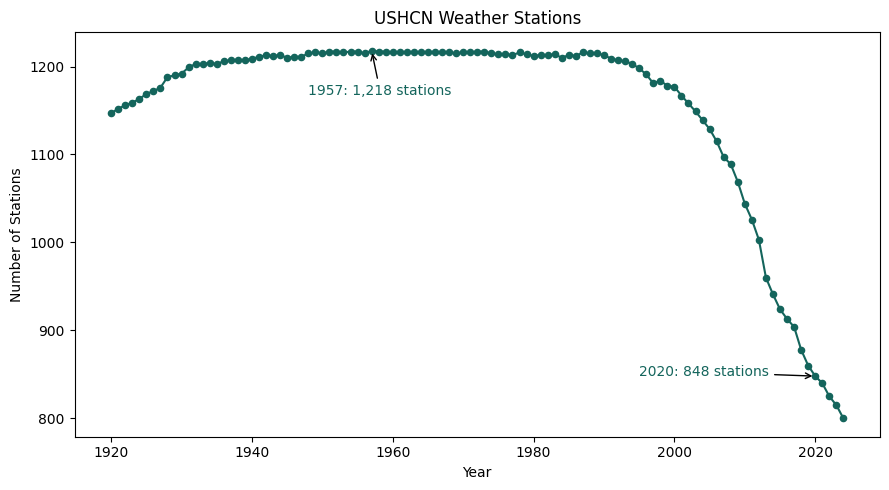

In [17]:
years = stations['year']
n_stations = stations['n_stations']
custom_color = '#14655C'

# Create the plot
plt.figure(figsize=(9, 5))
plt.plot(years, n_stations, color=custom_color)
plt.scatter(years, n_stations, color=custom_color, marker='o', s=20, label='Number of Stations')

# Annotate the points
plt.annotate(
    f'1957: {y_1957:,} stations',
    xy=(x_1957, y_1957),
    xytext=(x_1957 - 9, y_1957 - 50),
    arrowprops=dict(arrowstyle='->'),
    fontsize=10,
    color=custom_color
)

plt.annotate(
    f'2020: {y_2020:,} stations',
    xy=(x_2020, y_2020),
    xytext=(x_2020 - 25, y_2020),
    arrowprops=dict(arrowstyle='->'),
    fontsize=10,
    color=custom_color
)

# Label
plt.title('USHCN Weather Stations')
plt.xlabel('Year')
plt.ylabel('Number of Stations')
# plt.grid(True)

# Adjust layout to prevent label cutoff
plt.tight_layout()

### Replicate Chart 8 (4:57) - % of fabricated temp. reports

Conclusion:  seemingly perfectly replicated

In [18]:
def make_percent_fab_chart(df):
    altered = (
        df
        .filter(
            pl.col('element') == 'tmax',
            pl.col('dataset_type') == 'FLs.52j',
            pl.col('year') >= 1920,
            pl.col('value').is_not_null(),
        )
        .with_columns(
            pl.col('value').alias('temp_c'),
            (pl.col('value') * 9/5 + 32).alias('temp_f')
        )
        .drop(['element', 'dataset_type', 'value'])
        .group_by(['year'])
        .agg(
            pl.col('temp_c').is_not_null().sum().alias('n_reports'),
            (pl.col('dmflag') == 'E').sum().alias('n_estimated'),
        )
        .with_columns(
            (100 * pl.col('n_estimated') / pl.col('n_reports')).alias('percent_estimated'),
        )
        .sort('year')
    )

    # Plot the data
    plt.figure(figsize=(9, 5))
    plt.plot(altered['year'], altered['percent_estimated'], color='#6f0d02', linewidth=2, label='% Fabricated')
    plt.scatter(altered['year'], altered['percent_estimated'], color='#6f0d02', marker='o', s=20)
    plt.title('TMAX (1920-present)')
    plt.xlabel('Year')
    plt.ylabel('%')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

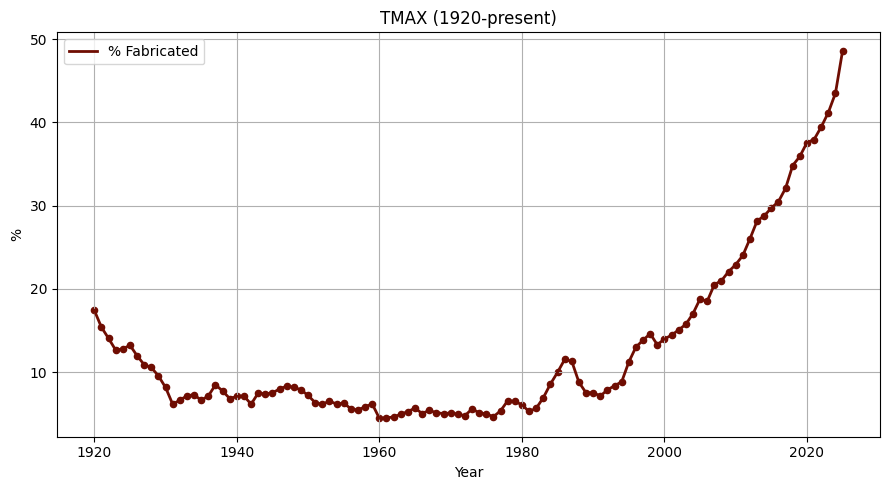

In [19]:
make_percent_fab_chart(df)

#### # Why are the temp. values different when dmflag is null for both raw and altered?
eg, coop_id=355734, year=1920, month=1..4

ffs, is this a common occurrence?

Yes, it is common AF...1,080,301 of 1,538,306 records.

In [20]:
raw = (
    df
    .filter(
        pl.col('element') == 'tmax',
        pl.col('dataset_type') == 'raw',
        pl.col('year') >= 1920,
        pl.col('value').is_not_null(),
    )
    .with_columns(
        pl.col('value').alias('temp_c'),
        (pl.col('value') * 9/5 + 32).alias('temp_f')
    )
    .drop(['element', 'dataset_type', 'value'])
)

In [21]:
altered = (
    df
    .filter(
        pl.col('element') == 'tmax',
        pl.col('dataset_type') == 'FLs.52j',
        pl.col('year') >= 1920,
        pl.col('value').is_not_null(),
    )
    .with_columns(
        pl.col('value').alias('temp_c'),
        (pl.col('value') * 9/5 + 32).alias('temp_f')
    )
    .drop(['element', 'dataset_type', 'value'])
)

In [22]:
(
    altered
    .join(
        raw,
        on=['coop_id', 'year', 'month'],
        how='left',
        suffix='_raw'
    )
    .filter(
        pl.col('dmflag').is_null(),
        pl.col('dmflag_raw').is_null(),
        pl.col('temp_c').is_not_null(),
        pl.col('temp_c_raw').is_not_null(),
        pl.col('temp_c') != pl.col('temp_c_raw'),
    )
)

coop_id,year,month,dmflag,qcflag,dsflag,temp_c,temp_f,dmflag_raw,qcflag_raw,dsflag_raw,temp_c_raw,temp_f_raw
str,u16,u8,str,str,str,f64,f64,str,str,str,f64,f64
"""355734""",1920,1,null,null,null,3.1,37.58,null,null,null,2.99,37.382
"""355734""",1920,2,null,null,null,5.86,42.548,null,null,null,5.7,42.26
"""355734""",1920,3,null,null,null,9.7,49.46,null,null,null,9.57,49.226
…,…,…,…,…,…,…,…,…,…,…,…,…
"""189440""",1998,10,null,null,null,18.53,65.354,null,null,null,19.22,66.596
"""189440""",1998,11,null,null,null,13.73,56.714,null,null,null,14.45,58.01
"""189440""",1999,2,null,null,null,8.4,47.12,null,null,null,9.23,48.614


#### What's the distribution of the deltas?

In [24]:
deltas = (
    altered
    .join(
        raw,
        on=['coop_id', 'year', 'month'],
        how='left',
        suffix='_raw'
    )
    .filter(
        pl.col('temp_f_raw').is_not_null(),
    )
    .with_columns(
        (pl.col('temp_f') - pl.col('temp_f_raw')).alias('adjustment_f'),
        (pl.col('temp_c') - pl.col('temp_c_raw')).alias('adjustment_c'),
    )
)
deltas

coop_id,year,month,dmflag,qcflag,dsflag,temp_c,temp_f,dmflag_raw,qcflag_raw,dsflag_raw,temp_c_raw,temp_f_raw,adjustment_f,adjustment_c
str,u16,u8,str,str,str,f64,f64,str,str,str,f64,f64,f64,f64
"""355734""",1920,1,null,null,null,3.1,37.58,null,null,null,2.99,37.382,0.198,0.11
"""355734""",1920,2,null,null,null,5.86,42.548,null,null,null,5.7,42.26,0.288,0.16
"""355734""",1920,3,null,null,null,9.7,49.46,null,null,null,9.57,49.226,0.234,0.13
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""189440""",2012,6,"""E""","""X""",null,28.0,82.4,null,null,null,27.19,80.942,1.458,0.81
"""189440""",2012,7,"""E""","""X""",null,31.91,89.438,null,null,null,31.27,88.286,1.152,0.64
"""189440""",2012,8,"""E""","""X""",null,29.3,84.74,null,null,null,29.51,85.118,-0.378,-0.21


<Axes: ylabel='Count'>

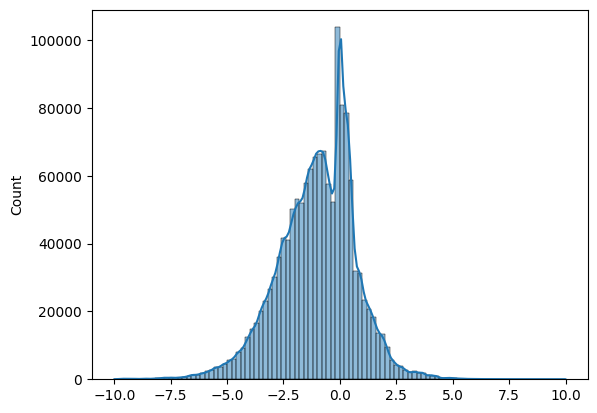

In [25]:
sns.histplot(deltas.filter(pl.col('adjustment_f').is_between(-10,10))['adjustment_f'], bins=100, kde=True)

In [26]:
def make_diffs_july_chart_v2():
    df = (
        deltas
        .filter(pl.col('month') == 7)
        .group_by(['year'])
        .agg(
            pl.col('adjustment_f').mean().alias('mean_adjustment_f'),
        )
        .sort('year')
    )

    # Plot the data
    plt.figure(figsize=(9, 5))
    plt.plot(df['year'], df['mean_adjustment_f'], color='grey', linewidth=2, label='Raw - Altered')
    plt.title('July TMAX (1895-present)\nRaw - Altered, not Mean')
    plt.xlabel('Year')
    plt.ylabel('Temperature Difference (°F)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()


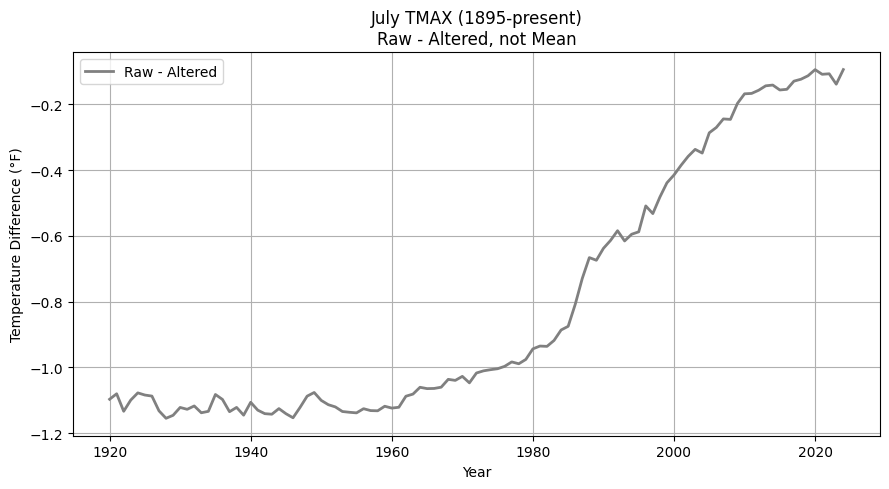

In [27]:
make_diffs_july_chart_v2()

### Belle Glade, FL example (6:11)

In [28]:
def belle_glade(df, dataset_type, value):
    return (
        df
        .filter(
            pl.col('element') == 'tmax',
            pl.col('dataset_type') == dataset_type,
            pl.col('coop_id') == '080611',
            pl.col('year') >= 2000,
        )
        .pivot(
            index='year',
            on='month',
            values=value,
        )
    )

In [30]:
belle_glade(df, 'raw', 'value')

year,1,2,3,4,5,6,7,8,9,10,11,12
u16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2000,25.12,25.5,29.07,29.2,32.18,32.76,33.4,33.41,33.25,29.76,27.44,25.77
2001,22.45,29.36,28.44,30.07,30.93,33.27,32.94,33.43,32.03,30.13,27.79,27.19
2002,25.73,25.66,29.2,30.71,31.95,null,null,null,null,null,null,null
2003,null,null,null,null,null,null,33.86,33.24,32.39,30.77,28.1,22.98
2004,23.96,25.87,null,null,null,null,null,null,null,null,null,null
2005,null,null,null,null,30.36,31.59,33.33,33.75,33.01,30.63,null,null


In [31]:
belle_glade(df, 'FLs.52j', 'value')

year,1,2,3,4,5,6,7,8,9,10,11,12
u16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2000,25.21,25.6,29.17,29.28,32.26,32.81,33.43,33.43,33.23,29.73,27.43,25.82
2001,22.54,29.46,28.54,30.15,31.01,33.32,32.97,33.45,32.01,30.1,27.78,27.24
2002,25.82,25.76,29.3,30.79,32.03,31.76,32.9,33.38,32.75,32.14,27.38,24.56
…,…,…,…,…,…,…,…,…,…,…,…,…
2023,26.85,29.31,29.92,31.31,31.92,33.48,34.86,35.1,33.56,31.15,28.26,25.3
2024,24.76,25.65,29.06,30.06,34.1,33.08,34.35,34.09,33.84,30.64,28.61,25.94
2025,22.57,28.56,28.46,null,null,null,null,null,null,null,null,null


In [32]:
belle_glade(df, 'FLs.52j', 'dmflag')

year,1,2,3,4,5,6,7,8,9,10,11,12
u16,str,str,str,str,str,str,str,str,str,str,str,str
2000,null,null,null,null,null,null,null,null,null,null,null,"""a"""
2001,null,null,null,null,null,null,"""b""",null,null,null,null,"""a"""
2002,null,null,"""a""",null,null,"""E""","""E""","""E""","""E""","""E""","""E""","""E"""
…,…,…,…,…,…,…,…,…,…,…,…,…
2023,"""E""","""E""","""E""","""E""","""E""","""E""","""E""","""E""","""E""","""E""","""E""","""E"""
2024,"""E""","""E""","""E""","""E""","""E""","""E""","""E""","""E""","""E""","""E""","""E""","""E"""
2025,"""E""","""E""","""E""",null,null,null,null,null,null,null,null,null


In [33]:
belle_glade(df, 'FLs.52j', 'qcflag')[2:]

year,1,2,3,4,5,6,7,8,9,10,11,12
u16,str,str,str,str,str,str,str,str,str,str,str,str
2002,null,null,null,null,null,null,null,null,null,null,null,null
2003,null,null,null,null,null,null,"""X""","""X""","""X""","""X""","""X""","""X"""
2004,"""X""","""X""",null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…
2023,null,null,null,null,null,null,null,null,null,null,null,null
2024,null,null,null,null,null,null,null,null,null,null,null,null
2025,null,null,null,null,null,null,null,null,null,null,null,null


In [34]:
belle_glade(df, 'FLs.52j', 'dsflag')

year,1,2,3,4,5,6,7,8,9,10,11,12
u16,str,str,str,str,str,str,str,str,str,str,str,str
2000,null,null,null,null,null,null,null,null,null,null,null,null
2001,null,null,null,null,null,null,null,null,null,null,null,null
2002,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…
2023,null,null,null,null,null,null,null,null,null,null,null,null
2024,null,null,null,null,null,null,null,null,null,null,null,null
2025,null,null,null,null,null,null,null,null,null,null,null,null
